In [363]:
from brainsmash.mapgen.memmap import txt2memmap
dist_mat_fin = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/B6_distance_matrix.txt"  # input text file
output_dir = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/B6/"  # directory to which output binaries are written
output_files = txt2memmap(dist_mat_fin, output_dir, maskfile=None, delimiter=' ')

In [ ]:
import os
import numpy as np
import pandas as pd
from brainsmash.mapgen.sampled import Sampled

# ==========================================
# PATHS
# ==========================================
metrics_dir = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/B6_MRI"
output_dir  = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/B6_surrogates"
os.makedirs(output_dir, exist_ok=True)

dist_mat_mmap = output_files['distmat']
index_mmap    = output_files['index']

# ==========================================
# LOOP THROUGH MRI METRICS
# ==========================================
for fname in os.listdir(metrics_dir):
    if not fname.endswith(".txt"):
        continue

    brain_map_file = os.path.join(metrics_dir, fname)
    metric_name = os.path.splitext(fname)[0]

    sampled = Sampled(brain_map_file, dist_mat_mmap, index_mmap)
    surrogates = sampled(n=1000)   # shape: (n_vertices, 1000)

    # save as CSV
    out_csv = os.path.join(output_dir, f"{metric_name}_surrogates.csv")
    pd.DataFrame(surrogates).to_csv(out_csv, index=False)

    print(f"Saved: {out_csv}")


In [368]:
out_path = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/B6_MRI/output/spearmanrvalues_B6_gene.npz"

# Create an empty npz container
np.savez(out_path)


In [379]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, rankdata

# =========================
# Paths
# =========================
base_dir = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/5xFAD_MRI"
data_dir = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_correlation"
out_dir  = os.path.join(base_dir, "output")

gene_type = "plaque_gene"

r_out = os.path.join(out_dir, f"spearmanrvalues_5xFAD_{gene_type}.npz")
p_out = os.path.join(out_dir, f"SA_corrected_spearmanpvalues_5xFAD_{gene_type}.npz")

# =========================
# Create empty NPZs ONCE
# =========================
if not os.path.exists(r_out):
    np.savez(r_out)

if not os.path.exists(p_out):
    np.savez(p_out)

# =========================
# Load gene data (once)
# =========================
df = pd.read_csv(
    f"{data_dir}/35xFAD_{gene_type}_expression_matrix_matchedspots_Ydata_updated_updated.csv",
    index_col=0
)
gene = df.to_numpy().T
gene = np.nan_to_num(gene, nan=0.0)

n_cols = gene.shape[0]

# =========================
# Helper functions
# =========================
def rank_rows(X):
    return np.apply_along_axis(rankdata, 1, X)

def corr_matrix_rows(X, Y):
    X = X - X.mean(axis=1, keepdims=True)
    Y = Y - Y.mean(axis=1, keepdims=True)

    X_std = np.linalg.norm(X, axis=1, keepdims=True)
    Y_std = np.linalg.norm(Y, axis=1, keepdims=True)

    return (X @ Y.T) / (X_std @ Y_std.T)

gene_rank = rank_rows(gene)

# =========================
# Find MRI metrics
# =========================
mri_files = sorted(glob.glob(os.path.join(base_dir, "5xFAD_*.txt")))
mri_files = [f for f in mri_files if "surrogates" not in f]

# =========================
# Loop
# =========================
for mri_path in mri_files:

    metric = os.path.basename(mri_path)\
        .replace("5xFAD_", "")\
        .replace(".txt", "")

    print(f"Processing {metric}")

    MRI = np.loadtxt(mri_path)
    surrogates = pd.read_csv(
        os.path.join("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/5xFAD_surrogates", f"5xFAD_{metric}_surrogates.csv")
    , header=None).to_numpy()

    map_rank = rank_rows(surrogates)
    surrogate_brainmap_corrs = corr_matrix_rows(gene_rank, map_rank)

    r_vals = np.zeros(n_cols)
    SA_corrected_p = np.zeros(n_cols)

    for i in range(n_cols):
        r_vals[i], _ = spearmanr(gene.T[:, i], MRI)
        SA_corrected_p[i] = nonparp(
            r_vals[i], surrogate_brainmap_corrs[i, :]
        )

    # -------------------------
    # Append results
    # -------------------------
    append_to_npz(r_out, **{metric: r_vals})
    append_to_npz(p_out, **{metric: SA_corrected_p})

# =========================
# Check saved keys
# =========================
print("R keys:", list(np.load(r_out).keys()))
print("P keys:", list(np.load(p_out).keys()))


Processing NDI
Processing QSM
Processing Rsoma
Processing ad
Processing ak
Processing fa
Processing fextra
Processing fneurite
Processing fsoma
Processing kfa
Processing md
Processing mkt
Processing odi
Processing rd
Processing rtk
R keys: ['NDI', 'QSM', 'Rsoma', 'ad', 'ak', 'fa', 'fextra', 'fneurite', 'fsoma', 'kfa', 'md', 'mkt', 'odi', 'rd', 'rtk']
P keys: ['NDI', 'QSM', 'Rsoma', 'ad', 'ak', 'fa', 'fextra', 'fneurite', 'fsoma', 'kfa', 'md', 'mkt', 'odi', 'rd', 'rtk']


In [ ]:
import numpy as np

data1 = np.load('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/B6/distmat.npy')
data2 = np.load('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/B6/index.npy')
print(type(data1))
print(type(data2))
output_files = {'distmat': data1, 'index': data2}

In [358]:
from brainsmash.mapgen.sampled import Sampled
import pandas as pd 

brain_map_file = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/B6_QSM.txt"  # use absolute paths if necessary!
dist_mat_mmap = output_files['distmat']
index_mmap = output_files['index']
sampled = Sampled(brain_map_file, dist_mat_mmap, index_mmap)
surrogates = sampled(n=1000)
#surrogates.to_csv('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/surrogates_B6_ad.csv', index=False)

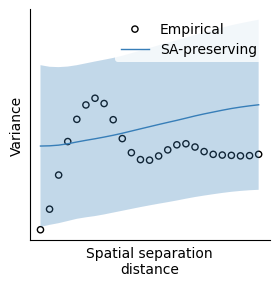

In [326]:
from brainsmash.mapgen.eval import sampled_fit
# from brainsmash.utils.eval import sampled_fit  analogous function for Sampled class
sampled_fit(brain_map_file, dist_mat_mmap, index_mmap, nsurr=200)

In [330]:
import numpy as np
import os

def append_to_npz(filename, **new_arrays):
    """Append new arrays to an existing .npz file (or create if missing)."""
    # Load existing data if file exists
    if os.path.exists(filename):
        old = dict(np.load(filename))
    else:
        old = {}

    # Update with new arrays
    old.update(new_arrays)

    # Save all arrays back
    np.savez(filename, **old)


In [359]:
import numpy as np
from brainsmash.mapgen.stats import pearsonr, pairwise_r
from scipy import stats
from brainsmash.mapgen.stats import nonparp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
from scipy.stats import rankdata

# load parcellated structural neuroimaging maps
MRI = np.loadtxt("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/B6_QSM.txt")

gene_type = "gene"
# Load CSV: index_col=0 removes the first column (index column)
df = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_correlation/3B6_" + gene_type + "_expression_matrix_matchedspots_Ydata.csv", index_col=0)
# Convert to NumPy array
gene = df.to_numpy().T
gene = np.nan_to_num(gene, nan=0.0)
print(gene.shape)
print(surrogates.shape)

n_cols = gene.shape[0]

def rank_rows(X):
    """
    Rank each row independently.
    """
    return np.apply_along_axis(rankdata, 1, X)

gene_rank = rank_rows(gene)      # (n_spots, n_genes)
map_rank  = rank_rows(surrogates)     # (n_spots, 1000)

def corr_matrix_rows(X, Y):
    """
    Pearson correlation between rows of X and rows of Y.
    X: (p, n)
    Y: (q, n)
    Returns: (p, q)
    """
    X = X - X.mean(axis=1, keepdims=True)
    Y = Y - Y.mean(axis=1, keepdims=True)

    X_std = np.linalg.norm(X, axis=1, keepdims=True)
    Y_std = np.linalg.norm(Y, axis=1, keepdims=True)

    return (X @ Y.T) / (X_std @ Y_std.T)


surrogate_brainmap_corrs = corr_matrix_rows(gene_rank, map_rank)
# print(surrogate_brainmap_corrs.shape)   # (n_genes, 1000)

# surrogate_brainmap_corrs = pearsonr(gene, surrogates)
# surrogate_brainmap_corrs = pearsonr(gene, surrogate_maps).flatten()


r_vals = np.zeros(n_cols)
p_vals = np.zeros(n_cols)
SA_corrected_p = np.zeros(n_cols)

# Compute correlation feature by feature
for i in range(n_cols):
    r_vals[i], p_vals[i] = spearmanr(gene.T[:, i], MRI)
    SA_corrected_p[i] = nonparp(r_vals[i], surrogate_brainmap_corrs[i,:])

# # this is the empirical statistic we're creating a null distribution for
# test_stat = stats.pearsonr(gene.T, MRI)[0]

# print("r-value:",r_vals)
# print("SA-corrected p-value:", SA_corrected_p)

# # First save something
# np.savez('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/spearmanrvalues_B6_' + gene_type + '.npz', AD=r_vals)
# np.savez('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/SA_corrected_spearmanpvalues_B6_' + gene_type + '.npz', AD=SA_corrected_p)

# Later append new arrays
append_to_npz('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/spearmanrvalues_B6_' + gene_type + '.npz', QSM=r_vals)
append_to_npz('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/SA_corrected_spearmanpvalues_B6_' + gene_type + '.npz', QSM=SA_corrected_p)

data = np.load('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/spearmanrvalues_B6_' + gene_type + '.npz')
print(list(data.keys()))  # ['X', 'Y', 'Z']
data2 = np.load('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/output/SA_corrected_spearmanpvalues_B6_' + gene_type + '.npz')
print(list(data2.keys()))  # ['X', 'Y', 'Z']

(19464, 5272)
(1000, 5272)


/var/folders/15/wmxts3lj69gg_wpvmbwxb9q00000gn/T/ipykernel_32836/4242481052.py:46: RuntimeWarning: invalid value encountered in divide
  return (X @ Y.T) / (X_std @ Y_std.T)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


['AD', 'FA', 'MD', 'RD', 'NDI', 'ODI', 'AK', 'KFA', 'MKT', 'RTK', 'Fextra', 'Fneurite', 'Fsoma', 'Rsoma', 'QSM']
['AD', 'FA', 'MD', 'RD', 'NDI', 'ODI', 'AK', 'KFA', 'MKT', 'RTK', 'Fextra', 'Fneurite', 'Fsoma', 'Rsoma', 'QSM']


In [380]:
import numpy as np
import pandas as pd

# gene_type = "gene"
data = np.load('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/5xFAD_MRI/output/spearmanrvalues_5xFAD_' + gene_type + '.npz')
# Combine all arrays into one DataFrame (columns)
df = pd.concat({key: pd.DataFrame(data[key]) for key in data.files}, axis=1)

# Save to a single CSV
df.to_csv('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/5xFAD_MRI/output/spearmanrvalues_5xFAD_' + gene_type + '.csv', index=False)
print("rvalues.csv")
data2 = np.load('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/5xFAD_MRI/output/SA_corrected_spearmanpvalues_5xFAD_' + gene_type + '.npz')
df2 = pd.concat({key: pd.DataFrame(data2[key]) for key in data2.files}, axis=1)

# Save to a single CSV
df2.to_csv('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Spatial_autocorrelation/5xFAD_MRI/output/SA_corrected_spearmanpvalues_5xFAD_' + gene_type + '.csv', index=False)
print("SA_corrected_pvalues.csv")

rvalues.csv
SA_corrected_pvalues.csv


In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# =========================
# PARAMETERS
# =========================
CSV_PATH = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/Three5xFAD_oligo_gene_MRI_merged_comparisonregions_cc.csv"
LABEL_COL = "templateLabelABA"
QSM_COL = "QSM"
GENE_START_COL = 26          # 0-based index → column 27
N_PERM = 1000
ALPHA = 0.05
RANDOM_STATE = 0

OUT_PREFIX = "5xFAD_oligo_gene_cc_spearman"

rng = np.random.default_rng(RANDOM_STATE)

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(CSV_PATH)

gene_cols = df.columns[GENE_START_COL:]
print(f"Number of genes: {len(gene_cols)}")

# =========================
# LABEL-WISE MEANS
# =========================
grouped = df.groupby(LABEL_COL)

QSM_mean = grouped[QSM_COL].mean().to_numpy()          # (n_labels,)
GENE_mean = grouped[gene_cols].mean().to_numpy()       # (n_labels, n_genes)

n_labels, n_genes = GENE_mean.shape
print(f"Labels: {n_labels}, Genes: {n_genes}")

# =========================
# COMBINED QSM + GENE MEANS
# =========================

# Preserve label order from groupby
labels = grouped[LABEL_COL].mean().index.to_numpy()

combined_df = pd.DataFrame(
    GENE_mean,
    columns=gene_cols
)

combined_df.insert(0, "QSM_mean", QSM_mean)
combined_df.insert(0, "templateLabelABA", labels)

combined_df.to_csv(
    f"{OUT_PREFIX}_QSM_GENE_mean_byLabel.csv",
    index=False
)


# =========================
# OBSERVED SPEARMAN r
# =========================
r_obs = np.zeros(n_genes)

for g in range(n_genes):
    r_obs[g], _ = spearmanr(QSM_mean, GENE_mean[:, g])

# =========================
# PERMUTATION TEST (QSM ONLY)
# =========================
r_perm = np.zeros((N_PERM, n_genes))

for k in range(N_PERM):
    QSM_perm = rng.permutation(QSM_mean)

    for g in range(n_genes):
        r_perm[k, g], _ = spearmanr(QSM_perm, GENE_mean[:, g])

# =========================
# TWO-SIDED PERMUTATION p
# =========================
p_vals = np.zeros(n_genes)

for g in range(n_genes):
    p_vals[g] = (
        1 + np.sum(np.abs(r_perm[:, g]) >= np.abs(r_obs[g]))
    ) / (1 + N_PERM)

# =========================
# FDR CORRECTION (BH)
# =========================
rej, q_vals, _, _ = multipletests(
    p_vals,
    alpha=ALPHA,
    method="fdr_bh"
)

# =========================
# RESULTS TABLE
# =========================
results = pd.DataFrame({
    "gene": gene_cols,
    "spearman_r": r_obs,
    "p_value": p_vals,
    "q_value_FDR": q_vals,
    "significant_FDR_0.05": rej
})

results.to_csv(
    f"{OUT_PREFIX}_spearman_SA_FDR.csv",
    index=False
)

print(f"Significant genes (FDR<{ALPHA}): {rej.sum()}")

# =========================
# VOLCANO PLOT
# =========================
eps = 1e-300

plt.figure(figsize=(6, 5))

plt.scatter(
    results["spearman_r"],
    -np.log10(results["q_value_FDR"] + eps),
    s=8,
    alpha=0.6
)

sig = results["significant_FDR_0.05"]

plt.scatter(
    results.loc[sig, "spearman_r"],
    -np.log10(results.loc[sig, "q_value_FDR"] + eps),
    s=10
)

plt.axhline(-np.log10(ALPHA), linestyle="--")
plt.axvline(0, linestyle="--")

plt.xlabel("Spearman r (QSM vs gene)")
plt.ylabel("-log10(FDR q-value)")
plt.title("Volcano plot: QSM–gene associations")

plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_volcano.png", dpi=300)
plt.close()

# =========================
# QQ PLOT
# =========================
p_sorted = np.sort(p_vals)
n = len(p_sorted)
expected = np.arange(1, n + 1) / (n + 1)

plt.figure(figsize=(5, 5))

plt.scatter(
    -np.log10(expected),
    -np.log10(p_sorted),
    s=8,
    alpha=0.6
)

maxv = max(
    -np.log10(expected).max(),
    -np.log10(p_sorted).max()
)

plt.plot([0, maxv], [0, maxv], linestyle="--")

plt.xlabel("Expected -log10(p)")
plt.ylabel("Observed -log10(p)")
plt.title("QQ plot (permutation p-values)")

plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_QQplot.png", dpi=300)
plt.close()

# =========================
# EXPORT SIGNIFICANT LISTS
# =========================
sig_genes = results[results["significant_FDR_0.05"]]
sig_pos = sig_genes[sig_genes["spearman_r"] > 0]
sig_neg = sig_genes[sig_genes["spearman_r"] < 0]

sig_genes.to_csv(
    f"{OUT_PREFIX}_significant_FDR05.csv",
    index=False
)

sig_pos.to_csv(
    f"{OUT_PREFIX}_significant_positive_FDR05.csv",
    index=False
)

sig_neg.to_csv(
    f"{OUT_PREFIX}_significant_negative_FDR05.csv",
    index=False
)

sig_pos["gene"].to_csv(
    f"{OUT_PREFIX}_positive_geneList.txt",
    index=False,
    header=False
)

sig_neg["gene"].to_csv(
    f"{OUT_PREFIX}_negative_geneList.txt",
    index=False,
    header=False
)

print("Pipeline finished successfully.")


Number of genes: 148
Labels: 4, Genes: 148
Significant genes (FDR<0.05): 0
Pipeline finished successfully.


In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats.multitest import multipletests

# =========================
# PARAMETERS
# =========================
CSV_PATH = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/Three5xFAD_plaque_gene_MRI_merged_comparisonregions_cortex.csv"
LABEL_COL = "templateLabelABA"
QSM_COL = "QSM"
GENE_START_COL = 26
N_PERM = 1000
N_COMPONENTS = 2
ALPHA = 0.05
RANDOM_STATE = 0

OUT_PREFIX = "PLS_5xFAD_plaque_plaque_gene_cortex"

rng = np.random.default_rng(RANDOM_STATE)

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(CSV_PATH)
gene_cols = df.columns[GENE_START_COL:]

# =========================
# LABEL-WISE MEANS
# =========================
grouped = df.groupby(LABEL_COL)

QSM_mean = grouped[QSM_COL].mean().to_numpy()          # (n_labels,)
GENE_mean = grouped[gene_cols].mean().to_numpy()       # (n_labels, n_genes)

labels = grouped[LABEL_COL].mean().index.to_numpy()

n_labels, n_genes = GENE_mean.shape
print(f"Labels: {n_labels}, Genes: {n_genes}")

# =========================
# COMBINED QSM + GENE MEANS
# =========================

combined_df = pd.DataFrame(
    GENE_mean,
    columns=gene_cols
)

combined_df.insert(0, "QSM_mean", QSM_mean)
combined_df.insert(0, "templateLabelABA", labels)

combined_df.to_csv(
    f"{OUT_PREFIX}_QSM_GENE_mean_byLabel.csv",
    index=False
)

# =========================
# STANDARDIZE X and y
# =========================
X = (GENE_mean - GENE_mean.mean(axis=0)) / GENE_mean.std(axis=0, ddof=1)
y = (QSM_mean - QSM_mean.mean()) / QSM_mean.std(ddof=1)
y = y.reshape(-1, 1)

# =========================
# FIT PLS (OBSERVED)
# =========================
pls = PLSRegression(n_components=N_COMPONENTS)
pls.fit(X, y)

# Gene weights for component 1
gene_weights_obs = pls.x_weights_[:, 0]   # (n_genes,)

# =========================
# PERMUTATION TEST (QSM)
# =========================
gene_weights_perm = np.zeros((N_PERM, n_genes))

for k in range(N_PERM):
    y_perm = rng.permutation(y.flatten()).reshape(-1, 1)

    pls_perm = PLSRegression(n_components=N_COMPONENTS)
    pls_perm.fit(X, y_perm)

    gene_weights_perm[k, :] = pls_perm.x_weights_[:, 0]

# =========================
# TWO-SIDED p-VALUES
# =========================
p_vals = np.zeros(n_genes)

for g in range(n_genes):
    p_vals[g] = (
        1 + np.sum(np.abs(gene_weights_perm[:, g]) >= np.abs(gene_weights_obs[g]))
    ) / (1 + N_PERM)

# =========================
# FDR CORRECTION
# =========================
rej, q_vals, _, _ = multipletests(
    p_vals,
    alpha=ALPHA,
    method="fdr_bh"
)

# =========================
# RESULTS TABLE
# =========================
results = pd.DataFrame({
    "gene": gene_cols,
    "PLS_weight": gene_weights_obs,
    "p_value": p_vals,
    "q_value_FDR": q_vals,
    "significant_FDR_0.05": rej
})

results.to_csv(
    f"{OUT_PREFIX}_results.csv",
    index=False
)

print(f"Significant genes (FDR<{ALPHA}): {rej.sum()}")

# =========================
# VOLCANO PLOT (PLS)
# =========================
eps = 1e-300

plt.figure(figsize=(6, 5))
plt.scatter(
    results["PLS_weight"],
    -np.log10(results["q_value_FDR"] + eps),
    s=8,
    alpha=0.6
)

sig = results["significant_FDR_0.05"]
plt.scatter(
    results.loc[sig, "PLS_weight"],
    -np.log10(results.loc[sig, "q_value_FDR"] + eps),
    s=10
)

plt.axhline(-np.log10(ALPHA), linestyle="--")
plt.axvline(0, linestyle="--")

plt.xlabel("PLS gene weight (Component 1)")
plt.ylabel("-log10(FDR q-value)")
plt.title("PLS: Gene contributions to QSM")

plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_volcano.png", dpi=300)
plt.close()

# =========================
# EXPORT SIGNIFICANT LISTS
# =========================
sig_genes = results[results["significant_FDR_0.05"]]
sig_pos = sig_genes[sig_genes["PLS_weight"] > 0]
sig_neg = sig_genes[sig_genes["PLS_weight"] < 0]

sig_genes.to_csv(
    f"{OUT_PREFIX}_significant_FDR05.csv",
    index=False
)

sig_pos["gene"].to_csv(
    f"{OUT_PREFIX}_positive_geneList.txt",
    index=False,
    header=False
)

sig_neg["gene"].to_csv(
    f"{OUT_PREFIX}_negative_geneList.txt",
    index=False,
    header=False
)

print("PLS pipeline finished successfully.")


Labels: 93, Genes: 52
Significant genes (FDR<0.05): 0
PLS pipeline finished successfully.
